<a href="https://colab.research.google.com/github/Idewan/AI-ML-Society-Workshops/blob/main/adversarial_workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adversarial Example Workshop

This lecture and workshop will focus on adversarial examples in image classification tasks.

Let's first have a small presentation on:
*   What are Adversarial Examples?
*   Why should we care about Adversarial Examples as ML engineers/researchers/students?
*   Why do they exist? Shift in the understanding of their existence.

In this notebook, we will present the Fast Gradient Sign Method [FGSM]. This is a simple one-step white box attack that is still used to this day as a quick evaluation of the robustness of CNNs. However, as with all evaluations, it is always recommended to include more than one attacks of different kinds (black-box, iterative, etc.) to truly demonstrate that your networks is indeed robust to an extent to adversarial attacks.

---

#Fast Gradient Sign Method (FGSM)

As for every adversarial examples, we want to find the minimum perturbation such that we change the original label of the image to an alternate one.

Given a trained DL model $f$ and an original input image $x$, generating an adversarial example $x'$ can be desribed as a box-constrained optimization problem:

$${min_{x'} ||x'- x||}$$
$$f(x') = l', f(x)=l, l \neq l', x' \in [0,1]  $$

What this says is simply that we want for an input image $x$ with associated label $l$ and model $f$ such that $f(x)=l$ to find a perturbation $\alpha$ such that $x' = x + \alpha$ where $f(x') = l'$. We are only succesful if the perturbed label $l'$ is different from original label $l$.

As was stated in the presentation, the focus of Adversarial Example research is to find attacks and to build defences such that in the future, we will have more robust networks. However, the existence of Adversarial Examples point at an inherent flaw of CNNs in that they often fail to extract key features in classes. So while we must have a good idea about how CNNs work, this workshop is not going to focus on that. Instead because DL is widely regarded as a "black box" technique - we know that it performs well but with limited knowledge on how it works, we will treat it as such as if we are to evaluate the robustness of a benchmark network.

In this workshop we will be using as our classification model $f$ Xception. If you want to learn more about Xception and how it is built and its successes please refer to this:

https://arxiv.org/abs/1610.02357

So let's get into it!


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

First we want to initialize our Xcpetion model and download the model weights from the Keras repository.

In [ ]:
pre_trained_model = tf.keras.applications.Xception(include_top=True,
                                                    weights="imagenet")
#Store input size in a variable
input_size = (299,299)

#Helper method to decode predictions
def decode_predictions_custom(model, image, top_classes_number):
  raw_predictions = model.predict(image)

  decoded_predictions = tf.keras.applications.xception.decode_predictions(raw_predictions,
                                                                          top=top_classes_number)
  class_name = decoded_predictions[0][0][1]
  top_confidence = decoded_predictions[0][0][2]
  return decoded_predictions, raw_predictions, class_name, top_confidence


Let's create some helper methods:

In [ ]:
#Preprocess image helper method
def preprocess_image(image_path, des_size):
  image_raw = tf.io.read_file(image_path)
  image = tf.image.decode_image(image_raw)
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, des_size)
  image = preprocess_input(image)
  image = image[None, ...]

  return image

#Show image helper method
def plot_single_image(image, caption):
  plt.figure()
  plt.imshow(image[0] * 0.5 + 0.5)
  plt.title(caption)
  plt.show()

def plot_six_images(image_arr, caption_arr):
  f, axarr = plt.subplots(2,3, figsize=(13,13))
  index = 0
  for i in range(0,2):
    for j in range(0,3):
      axarr[i,j].set_title(caption_arr[index])
      axarr[i,j].imshow(image_arr[index][0] *0.5 + 0.5)
      index+=1
    
  plt.show()



We will be using the ImageNet data set which comprises of 1000 classes. 

http://www.image-net.org/

Unfortunately, Keras does not have the ImageNet dataset ready for us to use. However, for this exercise we only need a few sample images. 

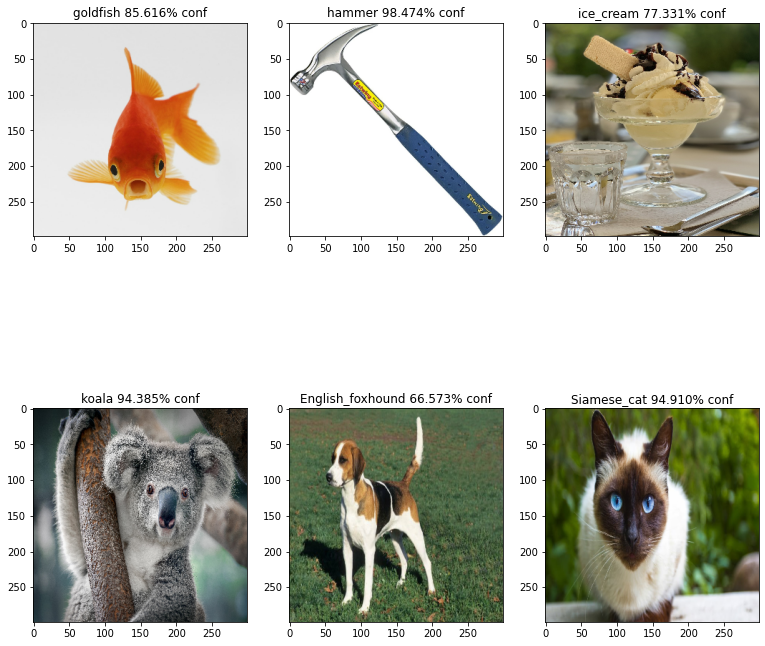

In [ ]:
image_names = ['gold_fish.jpg', 'hammer.jpg', 'icecream.jpg', 'koala_bear.jpg',
               'english_foxhound.jpeg', 'siamese_cat.jpg']
image_captions = []
image_probs = []

processed_images = [preprocess_image('sample_data/{}'.format(i), input_size) for i in image_names]

for i in range(0, len(processed_images)):
  _,raw_predictions, name, conf = decode_predictions_custom(pre_trained_model,
                                              processed_images[i], 1)
  image_captions.append("{} {:.3f}% conf".format(name, conf*100))
  image_probs.append(raw_predictions)

plot_six_images(processed_images, image_captions)


Now that we have 6 images that our model is able to predict pretty well, let's find some adversarial examples for these images!

##FGSM Methodology

FGSM, as we stated earlier, is a single step white box attack. Which means for this to work, we need access to the network's gradients but this method is very quick to compute as it is a single gradient step. 


Let $\theta$ be the parameters of a model, $x$ be the initial input, $l$ be the target label such that our cost function is given by $J(\theta, x, l)$. In this attack we compute a single step of the gradient of the cost function, $J(\theta, x, l)$, with respect to $x$.

$$\eta = \epsilon sign(\nabla_xJ(\theta, x, l)$$

Where epsilon characterises the intensity of our filter. The full adversarial example $x'$ is given by: $$x' = x + \eta$$ 
Let's have a look!

In [ ]:
#Method to create adversarial examples based on the FGSM method
def create_adversarial_fgsm(model, input_img, input_label):
  """
      Creates an adversarial eexample based on the fast gradient sign method

      :param input_img: Input image to be perturbed
      :param input_label: Input image's label
      :return: returns eta - the linear perturbation
  """
  loss_object = tf.keras.losses.CategoricalCrossentropy()

  with tf.GradientTape() as tape:
    tape.watch(input_img)
    prediction = pre_trained_model(input_img)
    loss = loss_object(input_label, prediction)
  
  #Obtain gradient with respect to input image
  gradient = tape.gradient(loss, input_img)

  #Obtain signed gradient
  signed_grad = tf.sign(gradient)

  return signed_grad

Let's attack the model now.

Original Image


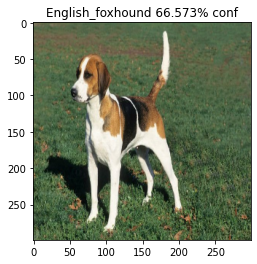

Perturbation


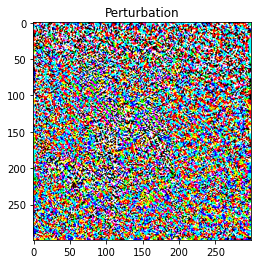

In [ ]:
#Generally we would have a file with all of the indeces
#Here we simply take the six needed
image_indeces = [1, 587, 928, 105, 167, 284]

#Let's checkout what happens when we try to perturb the dog image
image_index = image_indeces[4]
label = tf.one_hot(image_index, image_probs[4].shape[-1])
label = tf.reshape(label, (1, image_probs[4].shape[-1]))
perturbation = create_adversarial_fgsm(pre_trained_model, processed_images[4], label)

perturbations = [perturbation] * 6


print("Original Image")
plot_image(processed_images[4], image_captions[4])

print("Perturbation")
plot_image(perturbation, 'Perturbation')

Now let's try different epsilon values and see how it both affects our model's predictions and the way, us humans, perceive the image. Remember: $$\epsilon \in [0,1]$$

In [ ]:
#Let's create a helper method for our experiments with epsilon
def experiment_epsilon(epsilon, class_index, perturbation):
  """
    For the purpose of this workshop we will keep all experiments of size 6. This
    is due to the our helper method which shows an image plot of 6.
  """ 
  experiment_captions = []
  experiment_images = []

  for i in range(len(epsilon)):
    perturbed_image = processed_images[class_index] + epsilon[i] * perturbation
    _,_,class_name, confidence = decode_predictions_custom(pre_trained_model,
                                                          perturbed_image, 1)
    experiment_captions.append("{} {} {:.3f}% conf".format(epsilon[i], class_name, 
                                                          confidence*100))
    perturbed_image = tf.clip_by_value(perturbed_image, -1, 1)
    
    experiment_images.append(perturbed_image)

  return experiment_captions, experiment_images

#Let's create a helper method for our other experiments
def experiment(processed_images, perturbations, epsilon=0.007):
  """
    For the purpose of this workshop we will keep all experiments of size 6. This
    is due to the our helper method which shows an image plot of 6.
  """ 
  experiment_captions = []
  experiment_images = []

  for i in range(len(processed_images)):
    perturbed_image = processed_images[i] + epsilon * perturbations[i]
    _,_,class_name, confidence = decode_predictions_custom(pre_trained_model,
                                                          perturbed_image, 1)
    experiment_captions.append("{} {} {:.3f}% conf".format(epsilon, class_name, 
                                                          confidence*100))
    perturbed_image = tf.clip_by_value(perturbed_image, -1, 1)
    
    experiment_images.append(perturbed_image)

  return experiment_captions, experiment_images

Let's experiments with different epsilons now:

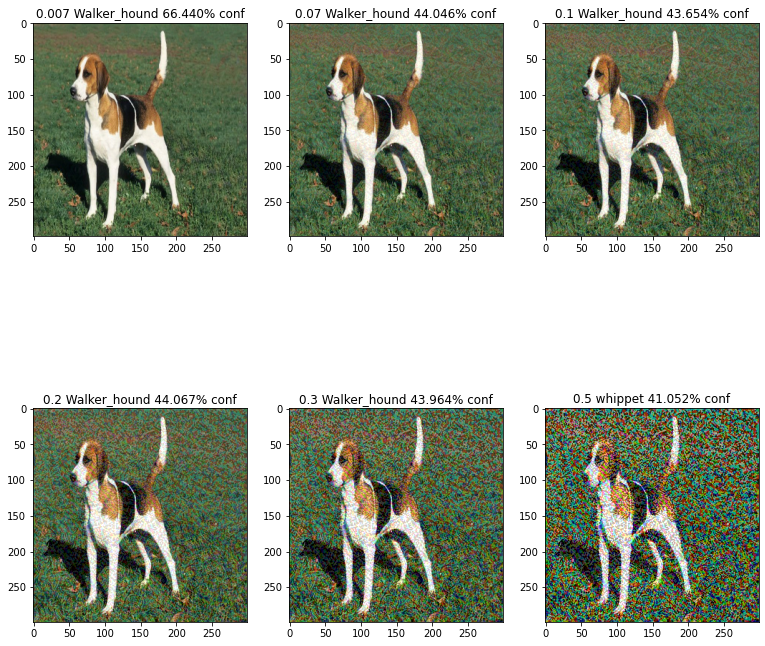

In [ ]:
#Epsilon
epsilon = [0.007, 0.07, 0.1, 0.2, 0.3, 0.5]
experiment_captions, experiment_images = experiment_epsilon(epsilon, 4, perturbations[4])


plot_six_images(experiment_images, experiment_captions)

It works! Remark that the algorithm perturbed the image of the English Fox Hound (index 167) to a Walker Hound (index 166) when small perturbations were applied, this must mean that they are closely interconnected boundaries between the two classes. When the perturbation grew, the dog was classified to a Whippet which is 'human-wise' far from what an English Fox Hound looks like.

Let's see if the same perturbation also works for other images.

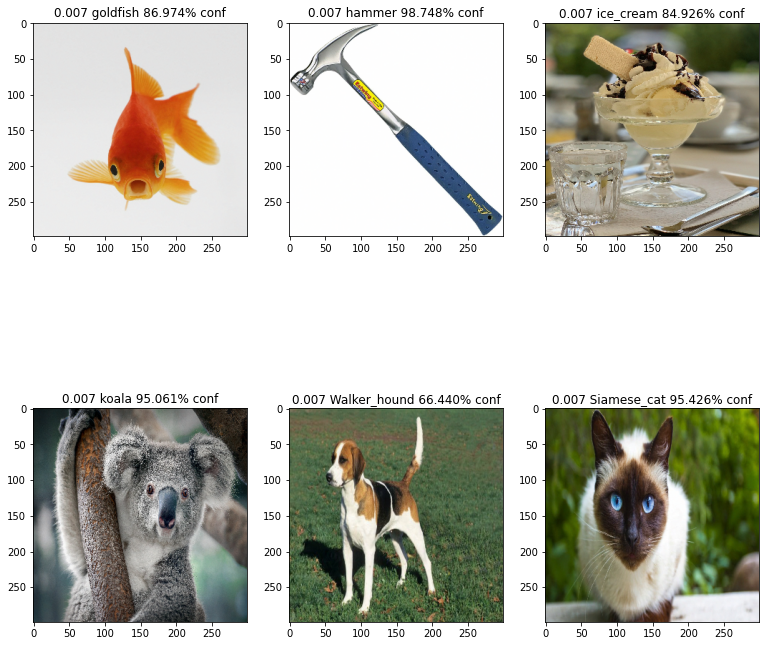

In [ ]:
#Let fix our epsilon to be 0.007. The purpose of adversarial examples is that 
#the changes are imperceptible to humans
experiment_2_captions, experiment_2_images = experiment(processed_images, perturbations)
plot_six_images(experiment_2_images, experiment_2_captions)

Not much success there...

Let's compute the perturbation for the rest of our images.

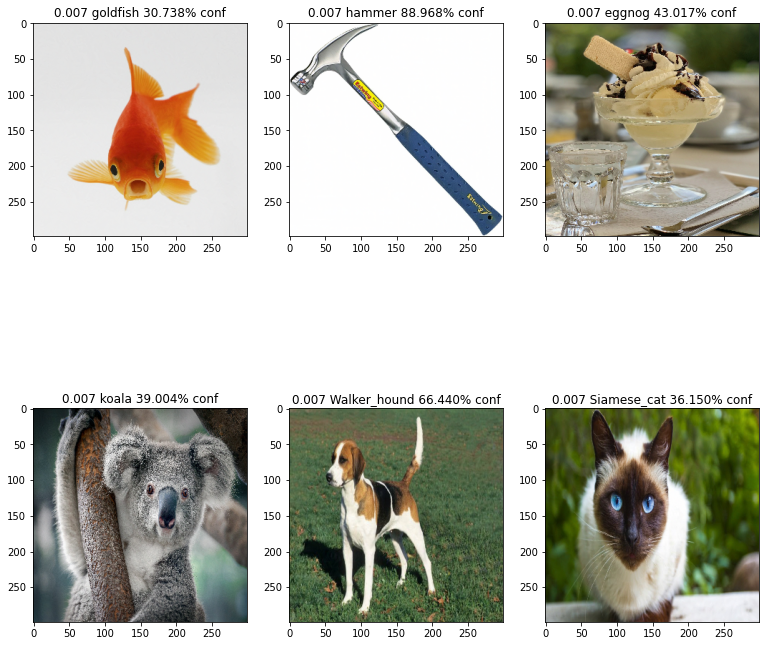

In [ ]:
for i in range(0, 6):
  if i is not 4:
    image_index = image_indeces[i]
    label = tf.one_hot(image_index, image_probs[i].shape[-1])
    label = tf.reshape(label, (1, image_probs[i].shape[-1]))
    perturbations[i] = create_adversarial_fgsm(pre_trained_model, 
                                               processed_images[i], label)

experiment_3_captions, experiment_3_images = experiment(processed_images, perturbations)
plot_six_images(experiment_3_images, experiment_3_captions)
    

We can see that the overall confidence dropped for all of the different images. Some were succesfully perturbed (dog, ice cream), however, the others whilst weakened (Koala from 94.39% to 39%, Siamese Cat 94.91% to 36.15%) we did not completely perturb those classes. So let's do an epsilon experiment on the Siamese cat, Koala Bear, Hammer and Goldfish.

Starting with the goldfish, koala and siamese cat. We will keep the hammer for later.

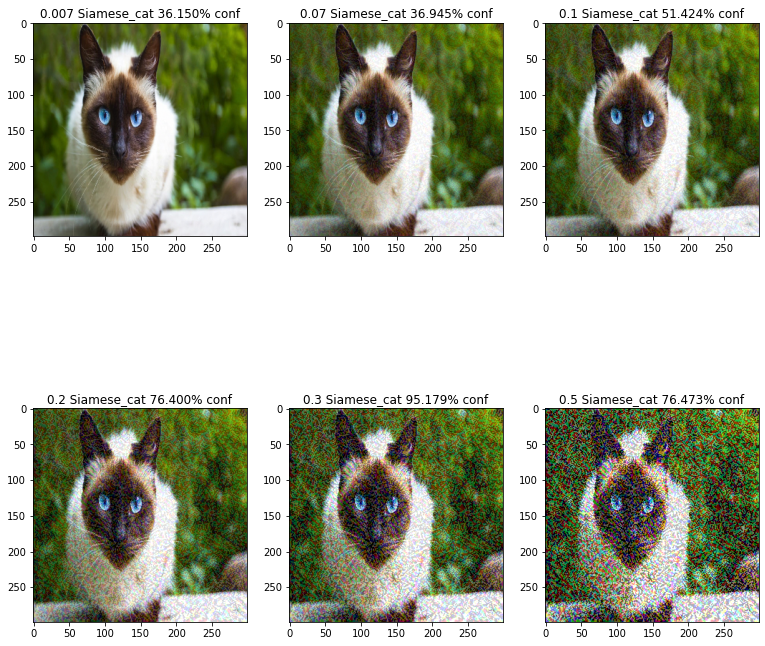

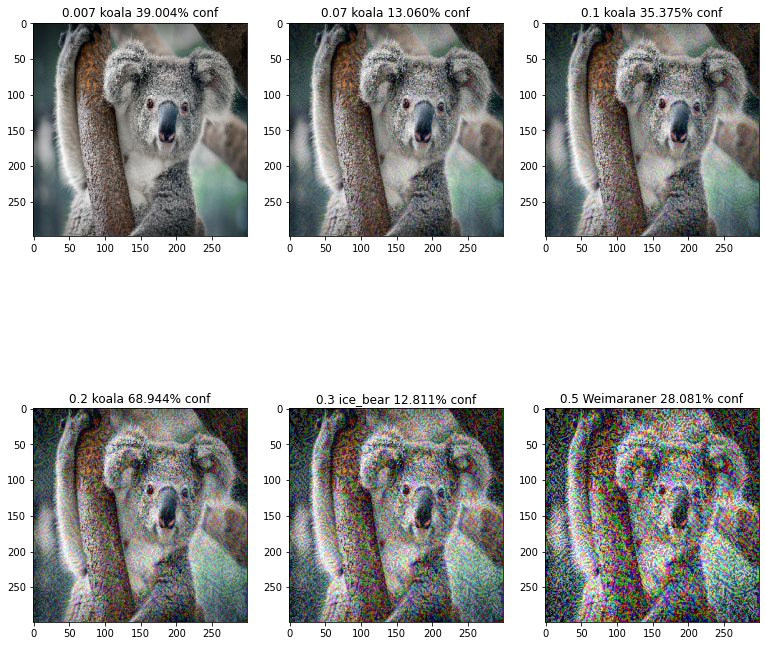

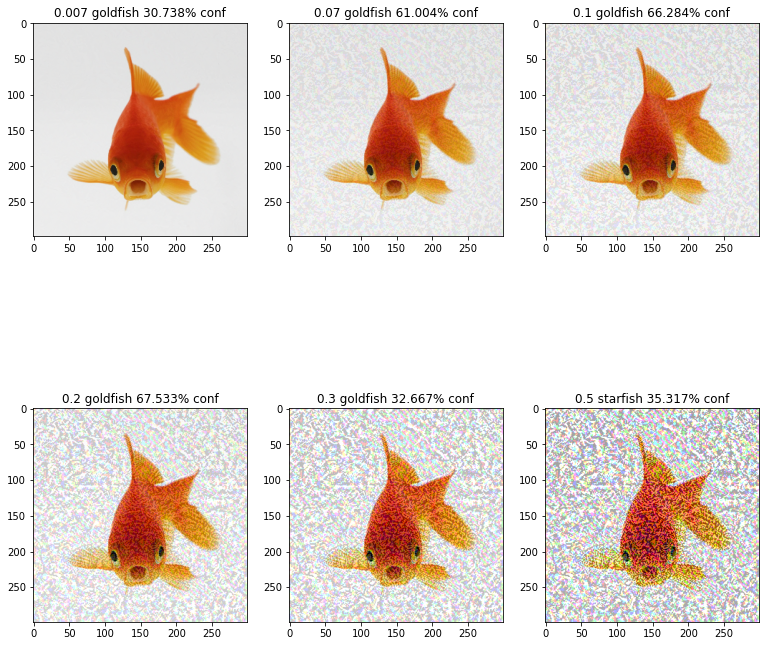

In [ ]:
experiment_cat_captions, experiment_cat_images = experiment_epsilon(epsilon, 5, perturbations[5])
experiment_koala_captions, experiment_koala_images = experiment_epsilon(epsilon, 3, perturbations[3])
experiment_goldfish_captions, experiment_goldfish_images = experiment_epsilon(epsilon, 0, perturbations[0])

plot_six_images(experiment_cat_images, experiment_cat_captions)
plot_six_images(experiment_koala_images, experiment_koala_captions)
plot_six_images(experiment_goldfish_images, experiment_goldfish_captions)

The perturbations are really class dependent and some images belonging to a specific class are sometimes harder to perturb than other images in different classes. 

The reason why the siamese cat is so difficult to perturb could be due to some of its key characteristics. The CNN architecture Xception could be extracting the key features such as blue eyes, different patterns for fur very well! We do not know! That's the issue with black box models. 

Keeping hammer for last, let's test our theory. A Hammer compared to the other classes is quite distinct. So let's see if we are able to perturb this class. 

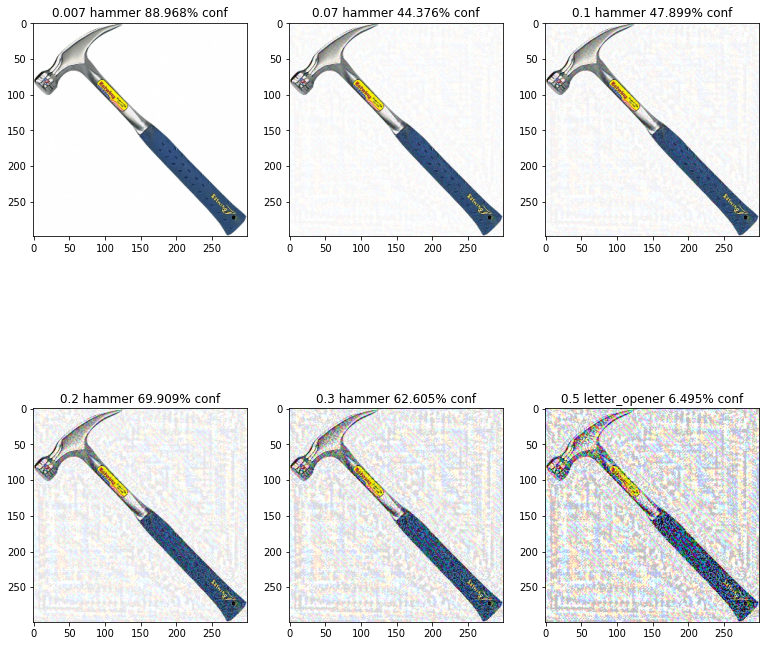

In [ ]:
experiment_hammer_captions, experiment_hammer_images = experiment_epsilon(epsilon, 1, perturbations[1])

plot_six_images(experiment_hammer_images, experiment_hammer_captions)

It is not until the very last epsilon value of 0.5 (heavy perturbation) that we are indeed able to perturb this hammer image, and this is at a very low confidence of 6.5%.